# 6 Classification, Regression
This section will cover logistic regression (which is a classification model) and linear regression. I first demonstrate how to train a logistic regression using the Iris dataset. As an exercise, you will train a linear regression on the Boston housing dataset.

This section will put together what we've learned so far. This section might seem hard at first, but the only new concept that will be introduced here is the `GradientDescentOptimizer`. As long as you understand the code step by step, it shouldn't be too hard.

## Logistic Regression

This example is adopted from [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.12/tutorials/mnist/pros/) tutorial from TensorFlow official website.

### Task

Classify a dataset of hand-written digits (0 through 9).

### Data

Let's load the data first. Thankfully, TensorFlow provided us a nice API. The data is also already split into train, validation and test set. In general, the data is way nastier...

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's take a look at the first image to get a sense of what's inside. Note that `next_batch` is also an API provided by TensorFlow which you generally have to code up yourself.

In [3]:
batch = mnist.train.next_batch(1)
plotData = batch[0]
plotData

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

There are $28\times 28=784$ pixels. $0$ means black and $1$ means white. Let's reshape it and use matplotlib to make it an image.

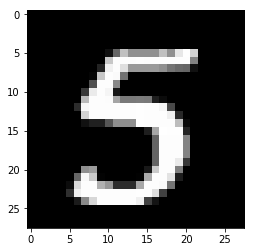

In [4]:
plotData = plotData.reshape(28, 28)
plt.gray() # use this line if you don't want to see it in color
plt.imshow(plotData)
plt.show()

### Overview

We will build a softmax regression. Softmax regression is just a multi-class generalization of logistic regression model:

$Y=softmax(WX+b)$
where

$Y: N \times K$

$X: N \times M$ 

$W: M \times N$

$b: K$

Here, $N$ can either be the train, validation, test sample size or the mini-batch size, depending on which part of the process you're in. $M$ is the number of features (784 in this case) and $K$ is the number of classes (10 in this case).

I really like to write down all the matrix dimensions before I start any coding. This way, I can avoid matrix dimension errors later on.

The loss we would like to optimize is the cross-entropy loss, averaged over the sample size:

$$\frac{-\sum_{n=1}^N \sum_{m=1}^M y_{n,m} log(\hat{y}_{n,m})}{N}$$

We will train this using gradient descent. 

Coding of this model is a six step process:
1. Define variables and placeholders.
2. Define the model.
3. Define the loss function.
4. Define the optimizer.
5. Train the model, i.e. initialize variables and run optimizer.
6. Evaluate the model.

This is the same for any other models. Neural nets will have this form too!

### Variables and Placeholders

$Y,X$ will be a placeholder, because we will feed in different datasets.

In [5]:
M = 784
K = 10

In [6]:
X = tf.placeholder(tf.float32, shape=[None, M])
Y = tf.placeholder(tf.float32, shape=[None, K])

$W,b$ will be variables, because we would like to mutate them every epoch of the gradient descent.

In [7]:
W = tf.Variable(tf.zeros([M, K]))
b = tf.Variable(tf.zeros([K]))

### Model
Softmax regression model is a one liner!

In [8]:
Yhat = tf.nn.softmax(tf.matmul(X, W) + b)

### Loss
The cross-entropy loss is also a one liner! Make sure to compare with the equation and check that it's doing what it's supposed to. We will also define accuracy for evaluating the result on the test set.

In [9]:
loss               = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(Yhat), axis=1))
correct_prediction = tf.equal(tf.argmax(Yhat, 1), tf.argmax(Y, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Optimizer
Here's somethig new to learn! `GradientDescentOptimizer` takes in the objective that we would like to minimize. Running this optimizer will look at all trainable variables that loss depends on and update them. There are many other optimizers e.g. `AdagradOptimizer`, `AdamOptimizer`. Find your favorite!

In [10]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
update = optimizer.minimize(loss)

### Initialize variables and run optimizer, evaluate the model

In [11]:
num_epochs  = 25
batch_size  = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    for epoch in range(num_epochs):
        average_cost = 0
        for _ in range(total_batch):
            batch_X, batch_Y = mnist.train.next_batch(batch_size)
            _, c = sess.run([update, loss], feed_dict={X: batch_X,
                                                          Y: batch_Y})
            average_cost += c / total_batch
        print("Epoch:",epoch,"Cost:",average_cost)
        
    print("Test Accuracy:", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels}))

Epoch: 0 Cost: 1.1839021801948548
Epoch: 1 Cost: 0.6654510486667813
Epoch: 2 Cost: 0.5529379929737613
Epoch: 3 Cost: 0.49868410809473573
Epoch: 4 Cost: 0.4655504615198485
Epoch: 5 Cost: 0.4425761844353241
Epoch: 6 Cost: 0.42555785720998596
Epoch: 7 Cost: 0.4121946653181855
Epoch: 8 Cost: 0.4014084171706979
Epoch: 9 Cost: 0.392443737387657
Epoch: 10 Cost: 0.38474309964613496
Epoch: 11 Cost: 0.37819437078454254
Epoch: 12 Cost: 0.3724136111953042
Epoch: 13 Cost: 0.367245780148289
Epoch: 14 Cost: 0.36276450005444655
Epoch: 15 Cost: 0.3585899773781949
Epoch: 16 Cost: 0.35486319644884645
Epoch: 17 Cost: 0.35145935565233233
Epoch: 18 Cost: 0.3483536499738691
Epoch: 19 Cost: 0.34543064494024583
Epoch: 20 Cost: 0.3427638471397486
Epoch: 21 Cost: 0.3402879169583317
Epoch: 22 Cost: 0.3379063183611087
Epoch: 23 Cost: 0.3357492735304615
Epoch: 24 Cost: 0.3337035980007869
Test Accuracy: 0.914


### Done!
To cite the `TensorFlow` documentation:

> Getting 92% accuracy on MNIST is bad. It's almost embarrassingly bad. In this section, we'll fix that, jumping from a very simple model to something moderately sophisticated: a small convolutional neural network. This will get us to around 99.2% accuracy -- not state of the art, but respectable.

## Exercise
Train a linear regression using gradient descent (no closed form!) that predicts housing prices in Boston from other covariates provided. Follow the six steps above. Plot the loss and observe that it goes down.

(Optional) Fit a LASSO. Fit a Ridge.

In [23]:
from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()

In [24]:
df = pd.DataFrame(boston.data)
df.columns = boston.feature_names
df['PRICE'] = boston.target

In [25]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
# TODO